# Custom Corolectal Cancer Pre-trained Model

### This notebook contains the implementation for the first pre-trained CNN encoder outlined as the first task of the project proposal. The architecture selected is ResNet and the implementation used comes from the `torchvision` module.

### Below are 4 different attempts at pre-training the model to find the ideal loop, optimizer and loss function that will yield the best performance for the model. The following 4 optimizers were selected.
- #### **SGD**
- #### **SGD + Momentum**
- #### **RMSProp**
- #### **Adam**

### Each loop utilizes the Categorical cross Entropy (CCE) loss function due to the presence of 3 distinct classes in the dataset (MUS, NORM, STR)

#### Initializations

In [1]:
import os
import numpy as np
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.metrics
from torch.utils.data import DataLoader, random_split
from torch.nn import Flatten
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE
from enum import Enum

class optimizer_choice(Enum):
    SGD = 0
    MOMENTUM = 1
    RMSPROP = 2
    ADAM = 3

print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

label_names = ["MUS", "NORM", "STR"]

# [Task 1]: Import and initialize ResNet50
resnet_corolectal_cancer_model = resnet50(weights=None, num_classes=3)
'''
Note that by default the ResNet implementations from PyTorch's source code follow the ImaegNet fully connected layer specification of 2048x1000.
    Therefore, for our project, we need to change it to use 3 classes according to the first dataset (MUS, NORM, STR).
    See the source code for the base class here (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).
    Stack Overflow post here (https://stackoverflow.com/questions/68980724/the-number-of-classes-in-pytorch-pretrained-model).

    Additionally, we will need to remove the last layer to be able to pass the features to a different learning algorithm in task 2.
    Here is a Stack Overflow post about it (https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch).

'''
# resnet_corolectal_cancer_model.fc = nn.Linear(2048, 3)
resnet_corolectal_cancer_model.to(device=device)
resnet_corolectal_cancer_model.train()

# [Task 1]: Import and initialize the optimizer algorithms
'''
Hyperparameters for vanilla SGD recommended settings: learning rate = 0.001
                                                      L2 regularizer penalty = 1e-6
                                                      Batch Size = 100
'''
learning_rate = 0.001
l2_regularizer = 1e-6
batch_size = 16
num_epochs = 5

sgd_no_momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

'''
Hyperparameters for SGD + momentum recommended settings: learning rate = 0.001
                                                         L2 regularizer penalty = 1e-6
                                                         Batch Size = 100
                                                         Momentum = 0.9
                                                         Nesterov = true
'''
momentum_term = 0.9
sgd_momentum_use_nesterov = True

momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(),
                            lr=learning_rate,
                            weight_decay=l2_regularizer,
                            momentum=momentum_term,
                            nesterov=sgd_momentum_use_nesterov)

'''
Hyperparameters for Adam recommended settings: learning rate = 0.001
                                               L2 regularizer penalty = 1e-6
                                               Batch Size = 100
                                               Beta 1 (Momentum) = 0.9
                                               Beta 2 (RMS decay rate) = 0.999
                                               Division stablizer = 1e-8
'''
adam_betas = (0.9, 0.999)
epsilon_division_stablizer = 1e-8

adam = optim.Adam(resnet_corolectal_cancer_model.parameters(),
                    lr=learning_rate,
                    weight_decay=l2_regularizer,
                    betas=adam_betas,
                    eps=epsilon_division_stablizer)

'''
Hyperparameters for RSMProp recommended settings: learning rate = 0.001
                                                  L2 regularizer penalty = 1e-6
                                                  Batch Size = 100
                                                  Decay rate = 0.999
                                                  Division stablizer = 1e-8
'''
rmsprop_decay_rate = adam_betas[1]

rmsprop = optim.RMSprop(resnet_corolectal_cancer_model.parameters(),
                        lr=learning_rate,
                        weight_decay=l2_regularizer,
                        alpha=rmsprop_decay_rate,
                        eps=epsilon_division_stablizer)

# [Task 1]: Import and initialize the t-SNE visualization algorithm
tsne = TSNE(random_state=42)

torch.cuda.is_available(): True


In [2]:
def plot_model_result(_losses, _accuracies, _num_batches, _val_losses, _val_accuracies, _mode_name="Training", _optimizer_name="SGD", _dataset_name="Corolectal Cancer"):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(np.arange(1, len(_losses) + 1), _losses, label=_mode_name)
    if len(_val_losses) > 1:
        momentum_loss_ax.plot(np.arange(1, len(_val_losses) + 1), _val_losses, label="Validation")
    momentum_loss_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(np.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{_mode_name} Epoch vs. Loss for {_dataset_name} Set ({_optimizer_name})")
    momentum_loss_ax.legend()
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(np.arange(1, len(_accuracies) + 1), _accuracies, label=_mode_name)
    if len(_val_accuracies) > 1:
        momentum_acc_ax.plot(np.arange(1, len(_val_accuracies) + 1), _val_accuracies, label="Validation")
    momentum_acc_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(np.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(np.arange(0, 110, 10))
    momentum_acc_ax.set_title(f"{_mode_name} Epoch vs. Accuracy for {_dataset_name} Set ({_optimizer_name})")
    momentum_acc_ax.legend()
    momentum_acc_ax.grid()

    plt.show()


def plot_metrics(_all_preds, _all_labels, _val_preds, _val_labels, _mode_name="Training"):
    print(f"[INFO] {_mode_name} Classification Report:")
    print(sklearn.metrics.classification_report(_all_labels, _all_preds, target_names=label_names))
    
    if len(_val_preds) > 1 and len(_val_labels) > 1:
        print(f"[INFO] Validation Classification Report:")
        print(sklearn.metrics.classification_report(_val_labels, _val_preds, target_names=label_names))

    print(f"[INFO] {_mode_name} Confusion Matrix:")
    matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(_all_labels, _all_preds), display_labels=label_names)
    matrix.plot()

    plt.show()

    if len(_val_preds) > 1 and len(_val_labels) > 1:
        print(f"[INFO] Validation Confusion Matrix:")
        matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(_val_labels, _val_preds), display_labels=label_names)
        matrix.plot()

        plt.show()


def do_model_epoch_loop(_model,
                        _data_loader,
                        _num_epochs,
                        _optimizer,
                        _val_data_loader = None,
                        _is_training=True,
                        _device="cpu",
                        _show_plot=True,
                        _optimizer_name="SGD",
                        _dataset_name="Corolectal_Cancer"):
    epoch_losses = []
    
    val_epoch_losses = []

    epoch_accuracies = []
    
    val_epoch_accuracies = []

    all_preds = []
    
    val_all_preds = []

    all_labels = []
    
    val_all_labels = []

    if _is_training:
        _model.train()
    else:
        _model.eval()

    num_batches = len(_data_loader)

    val_num_batches = 0
    if _val_data_loader != None:
        val_num_batches = len(_val_data_loader)

    for epoch in range(_num_epochs):
        total_epoch_loss = 0.0  # Track loss for the epoch

        total_epoch_acc = 0.0  # Track accuracy for the epoch

        epoch_preds = []

        epoch_true = []

        for inputs, labels in _data_loader:
            inputs, labels = inputs.to(_device), labels.to(_device)

            _optimizer.zero_grad()

            outputs = _model(inputs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
            if _is_training:
                loss.backward()  # Backward pass to compute gradients

                _optimizer.step()  # Update model parameters using gradients

            total_epoch_loss += loss.item()

            softmax_confidence_scores = F.softmax(outputs, dim=1)
            label_prediction = torch.argmax(softmax_confidence_scores, dim=1).view(-1)
            total_epoch_acc += ((label_prediction == labels).sum().item() / len(labels)) * 100

            # Append predictions and labels to the epoch lists
            epoch_preds.extend(label_prediction.detach().cpu().numpy())
            epoch_true.extend(labels.detach().cpu().numpy())

        epoch_losses.append(total_epoch_loss / num_batches)

        epoch_accuracies.append(total_epoch_acc / num_batches)

        all_preds = epoch_preds

        all_labels = epoch_true

        print(f"[INFO] Epoch {epoch + 1}/{_num_epochs}, Loss: {epoch_losses[epoch]:.4f}, Accuracy: {epoch_accuracies[epoch]:.2f}%")

        if _val_data_loader != None:
            _model.eval()

            val_total_loss = 0.0

            val_total_acc = 0.0

            val_preds = []

            val_true = []

            for inputs, labels in _val_data_loader:
                inputs, labels = inputs.to(_device), labels.to(_device)

                outputs = _model(inputs)  # Forward pass
                loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss

                val_total_loss += loss.item()

                softmax_confidence_scores = F.softmax(outputs, dim=1)
                label_prediction = torch.argmax(softmax_confidence_scores, dim=1).view(-1)
                val_total_acc += ((label_prediction == labels).sum().item() / len(labels)) * 100
                
                val_preds.extend(label_prediction.detach().cpu().numpy())
                
                val_true.extend(labels.detach().cpu().numpy())

            val_epoch_losses.append(val_total_loss / val_num_batches)

            val_epoch_accuracies.append(val_total_acc / val_num_batches)

            val_all_preds = val_preds

            val_all_labels = val_true

            print(f"[INFO] Validation loss: {val_epoch_losses[epoch]:.4f}, Validation accuracy: {val_epoch_accuracies[epoch]:.2f}%")

            _model.train()

    if _show_plot:
        if _num_epochs > 1:
            plot_model_result(epoch_losses,
                              epoch_accuracies,
                              num_batches,
                              val_epoch_losses,
                              val_epoch_accuracies,
                              "Training" if _is_training else "Test",
                              _optimizer_name,
                              _dataset_name)

        plot_metrics(all_preds, all_labels, val_all_preds, val_all_labels, "Training" if _is_training else "Test")

    if not _is_training:
        state_dict = _model.state_dict()
        torch.save(state_dict, f"Models/ResNet_{_optimizer_name}_{_dataset_name}_pre_trained.tar")

        print("[INFO] Saved the pre-trained model!")

    return epoch_losses, epoch_accuracies


def get_feature_and_label_maps(_model, _train_dataloader, _test_dataloader):
    for param in _model.parameters():
        param.requires_grad = False

    _model.to(device)

    full_train_feature_map_set = None

    full_train_label_set = None

    full_test_feature_map_set = None

    full_test_label_set = None

    flatten_layer = Flatten()

    for data, label in _train_dataloader:
        data, label = data.to(device), label.to(device)

        # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
        feature_map_dict = _model(data)
        flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

        if full_train_feature_map_set == None:
            full_train_feature_map_set = flattened_feature_map

            full_train_label_set = label
        else:
            full_train_feature_map_set = torch.vstack((full_train_feature_map_set, flattened_feature_map))
            
            full_train_label_set = torch.hstack((full_train_label_set, label))

    for data, label in _test_dataloader:
        data, label = data.to(device), label.to(device)

        # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
        feature_map_dict = _model(data)
        flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

        if full_test_feature_map_set == None:
            full_test_feature_map_set = flattened_feature_map

            full_test_label_set = label
        else:
            full_test_feature_map_set = torch.vstack((full_test_feature_map_set, flattened_feature_map))
            
            full_test_label_set = torch.hstack((full_test_label_set, label))

    return full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set


def create_embedding_dataframe(_full_train_feature_map_set, _full_train_label_set):
    reduction_fitter = TSNE(random_state=42)
    embeddings = reduction_fitter.fit_transform(_full_train_feature_map_set.cpu().numpy())
    embedding_dataframe = pandas.DataFrame(embeddings, columns=["x_embedded", "y_embedded"])
    embedding_dataframe["label"] = _full_train_label_set.cpu().numpy()

    return embedding_dataframe


def plot_tsne_embedding(_embedding_dataframe):
    colors = ["red", "green", "blue"]

    plt.style.use('seaborn-v0_8-dark')

    fig, ax = plt.subplots(figsize=(16,10))
    for i in _embedding_dataframe["label"].unique():
        label_embedding_values = _embedding_dataframe[_embedding_dataframe.label == i]
        ax.scatter(label_embedding_values.x_embedded, label_embedding_values.y_embedded, label=label_names[i], c=colors[i], alpha=0.5)

    ax.set_xlabel("Embedded Feature 1")
    ax.set_ylabel("Embedded Feature 2")

    ax.set_title("Feature Extractor Mappings Following TSNE Reduction")

    ax.legend()

    plt.show()


#### Data Preprocessing

In [3]:
'''
Source(s):
    - Key Steps in Data Preprocessing: https://www.techtarget.com/searchdatamanagement/definition/data-preprocessing
'''
# Optimizers
optimizer = optim.RMSprop(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
])

dataset_root = 'Datasets/Corolectal Cancer/'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' does not exist.")


full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

# Data Profiling: Check number of classes and their album size
if len(full_dataset) == 0:
    raise ValueError("The dataset is empty. Please check the image files.")

num_classes = len(full_dataset.classes)
if num_classes == 0:
    raise ValueError("Classes Detected: FAILED")
else:
    print(f"[INFO] Classes Detected: {num_classes}, CHECK")

# Display full dataset size
class_counts = np.bincount(full_dataset.targets)
for i, count in enumerate(class_counts):
    print(f"\t> {full_dataset.classes[i]}: {count} samples")

# Data Cleansing: Conditions to meet otherwise discarded warning
min_samples = 5
classes_to_remove = [full_dataset.classes[i] for i, count in enumerate(class_counts) if count < min_samples]
if classes_to_remove:
    print(f"[WARNING] Classes to remove due to low sample size: {classes_to_remove}")

# Data Validation: Split 80:20, DataLoaders for train/test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def check_dataloader(dataloader, name):
    try:
        inputs, labels = next(iter(dataloader))
        print(f"[INFO] {name} DataLoader is working: CHECK\n\t> Inputs size: {inputs.size()}, \n\t> Labels size: {labels.size()}")
    except Exception as e:
        raise RuntimeError(f"[ERROR] {name} DataLoader failed: {e}")

check_dataloader(train_dataloader, "Train")
check_dataloader(val_dataloader, "Validation")
check_dataloader(test_dataloader, "Test")

[INFO] Classes Detected: 3, CHECK
	> MUS: 2000 samples
	> NORM: 2000 samples
	> STR: 2000 samples
[INFO] Train DataLoader is working: CHECK
	> Inputs size: torch.Size([16, 3, 224, 224]), 
	> Labels size: torch.Size([16])
[INFO] Validation DataLoader is working: CHECK
	> Inputs size: torch.Size([16, 3, 224, 224]), 
	> Labels size: torch.Size([16])
[INFO] Test DataLoader is working: CHECK
	> Inputs size: torch.Size([16, 3, 224, 224]), 
	> Labels size: torch.Size([16])


#### SGD + Momentum

In [4]:
# Run this cell if a model was created with momentum and quick load is preferrable
resnet_corolectal_cancer_model.load_state_dict(torch.load("Models/ResNet_Momentum_Corolectal_Cancer_pre_trained.tar"))


C:\Users\trist\AppData\Local\Temp\ipykernel_29600\1367711442.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_corolectal_cancer_model.load_state_dict(torch.load("M

<All keys matched successfully>

[INFO] Starting training w/SGD + Momentum... CHECK
[INFO] Epoch 1/10, Loss: 0.9308, Accuracy: 54.45%
[INFO] Validation loss: 0.5894, Validation accuracy: 76.46%
[INFO] Epoch 2/10, Loss: 0.6079, Accuracy: 73.98%
[INFO] Validation loss: 0.5114, Validation accuracy: 77.08%
[INFO] Epoch 3/10, Loss: 0.5521, Accuracy: 76.85%
[INFO] Validation loss: 0.3678, Validation accuracy: 85.62%
[INFO] Epoch 4/10, Loss: 0.5069, Accuracy: 79.56%
[INFO] Validation loss: 0.4004, Validation accuracy: 84.38%
[INFO] Epoch 5/10, Loss: 0.4519, Accuracy: 81.80%
[INFO] Validation loss: 0.3073, Validation accuracy: 88.23%
[INFO] Epoch 6/10, Loss: 0.4081, Accuracy: 84.09%
[INFO] Validation loss: 0.2581, Validation accuracy: 89.17%
[INFO] Epoch 7/10, Loss: 0.3695, Accuracy: 86.07%
[INFO] Validation loss: 0.2404, Validation accuracy: 90.42%
[INFO] Epoch 8/10, Loss: 0.3391, Accuracy: 86.90%
[INFO] Validation loss: 0.2438, Validation accuracy: 90.31%
[INFO] Epoch 9/10, Loss: 0.2805, Accuracy: 89.14%
[INFO] Validation l

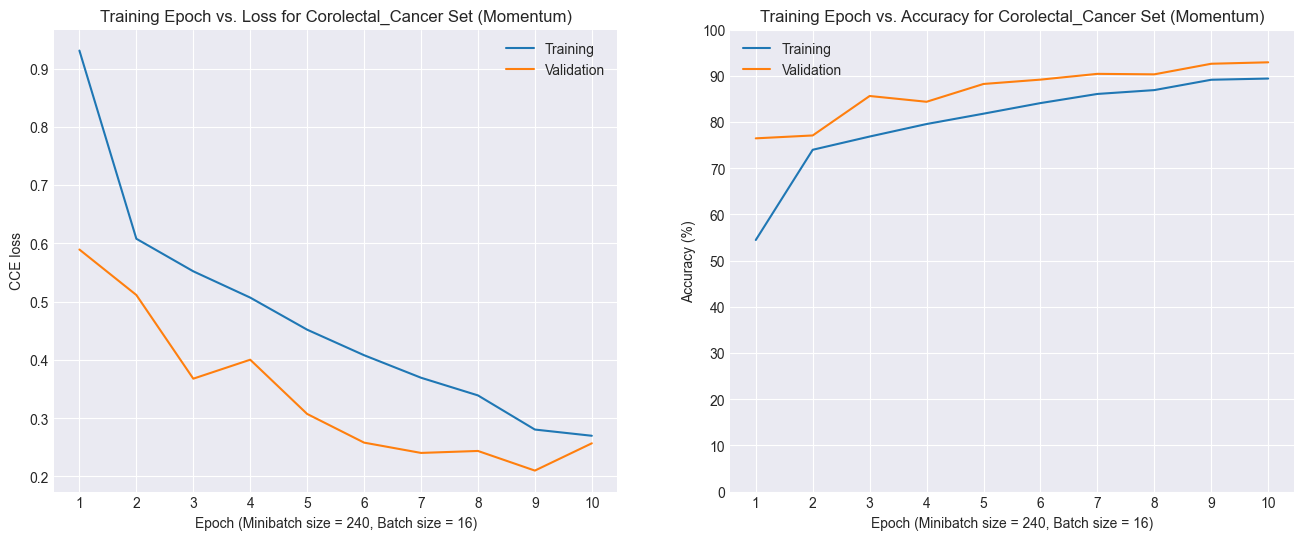

[INFO] Training Classification Report:
              precision    recall  f1-score   support

         MUS       0.88      0.88      0.88      1291
        NORM       0.95      0.96      0.95      1248
         STR       0.85      0.85      0.85      1301

    accuracy                           0.89      3840
   macro avg       0.89      0.89      0.89      3840
weighted avg       0.89      0.89      0.89      3840

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

         MUS       0.92      0.89      0.90       316
        NORM       0.94      0.99      0.96       332
         STR       0.92      0.91      0.92       312

    accuracy                           0.93       960
   macro avg       0.93      0.93      0.93       960
weighted avg       0.93      0.93      0.93       960

[INFO] Training Confusion Matrix:


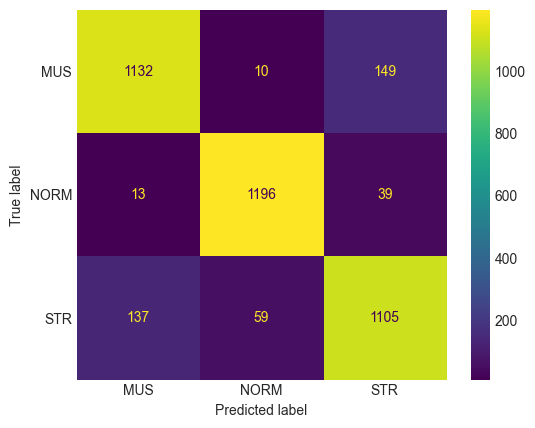

[INFO] Validation Confusion Matrix:


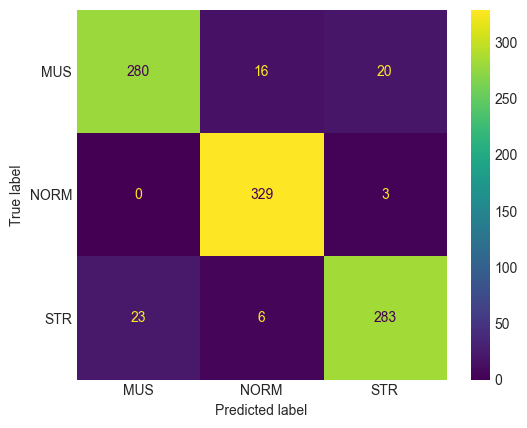

[INFO] Finished training w/SGD + Momentum!


In [7]:
# Training loop
print("[INFO] Starting training w/SGD + Momentum... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 10, momentum, _val_data_loader=val_dataloader, _device=device, _optimizer_name="Momentum")

print("[INFO] Finished training w/SGD + Momentum!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/1, Loss: 0.3307, Accuracy: 92.25%
[INFO] Test Classification Report:
              precision    recall  f1-score   support

         MUS       0.92      0.88      0.90       393
        NORM       0.90      0.99      0.94       420
         STR       0.96      0.89      0.92       387

    accuracy                           0.92      1200
   macro avg       0.93      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

[INFO] Test Confusion Matrix:


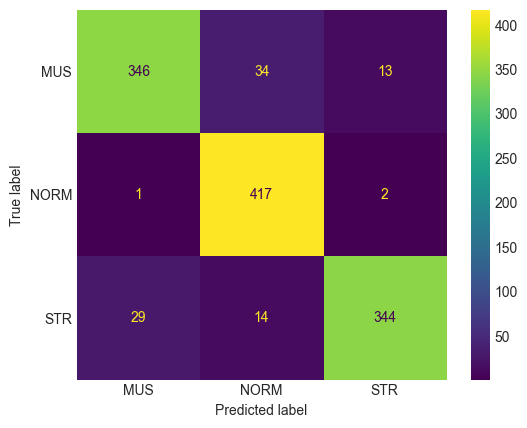

[INFO] Saved the pre-trained model!
[INFO] Finished training w/SGD + Momentum!


In [8]:
# Test set inference
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 1, momentum, _is_training=False, _device=device, _optimizer_name="Momentum")

print("[INFO] Finished training w/SGD + Momentum!")

In [5]:
return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
colorectal_model_extractor = create_feature_extractor(resnet_corolectal_cancer_model, return_nodes=return_nodes)


In [6]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(colorectal_model_extractor, train_dataloader, test_dataloader)


In [7]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


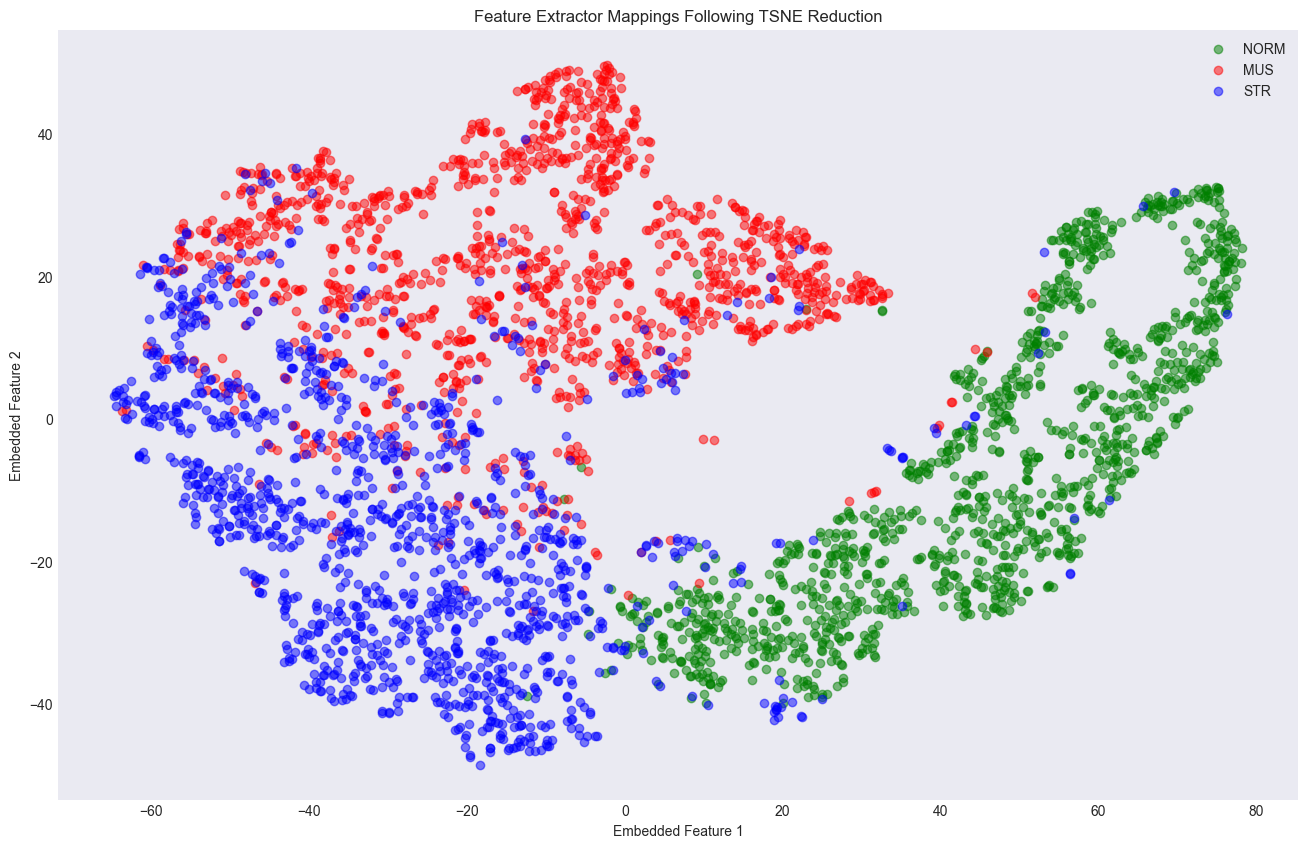

In [8]:
plot_tsne_embedding(embedding_dataframe)


#### RMSProp Optimizations

In [9]:
# Run this cell if a model was created with momentum and quick load is preferrable
resnet_corolectal_cancer_model.load_state_dict(torch.load("Models/ResNet_Rmsprop_Corolectal_Cancer_pre_trained.tar"))


C:\Users\trist\AppData\Local\Temp\ipykernel_10564\376203227.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_corolectal_cancer_model.load_state_dict(torch.load("Mo

<All keys matched successfully>

[INFO] Starting training w/RmsProp... CHECK
[INFO] Epoch 1/10, Loss: 1.2252, Accuracy: 59.06%
[INFO] Validation loss: 2.2684, Validation accuracy: 65.31%
[INFO] Epoch 2/10, Loss: 0.5966, Accuracy: 75.08%
[INFO] Validation loss: 2.1365, Validation accuracy: 66.67%
[INFO] Epoch 3/10, Loss: 0.4627, Accuracy: 81.43%
[INFO] Validation loss: 0.4137, Validation accuracy: 85.21%
[INFO] Epoch 4/10, Loss: 0.4052, Accuracy: 83.91%
[INFO] Validation loss: 0.3289, Validation accuracy: 87.08%
[INFO] Epoch 5/10, Loss: 0.3526, Accuracy: 85.76%
[INFO] Validation loss: 0.3311, Validation accuracy: 87.71%
[INFO] Epoch 6/10, Loss: 0.3195, Accuracy: 87.37%
[INFO] Validation loss: 0.2269, Validation accuracy: 91.67%
[INFO] Epoch 7/10, Loss: 0.2791, Accuracy: 89.58%
[INFO] Validation loss: 0.2811, Validation accuracy: 90.10%
[INFO] Epoch 8/10, Loss: 0.2810, Accuracy: 89.48%
[INFO] Validation loss: 0.2450, Validation accuracy: 92.08%
[INFO] Epoch 9/10, Loss: 0.2349, Accuracy: 91.41%
[INFO] Validation loss: 0.

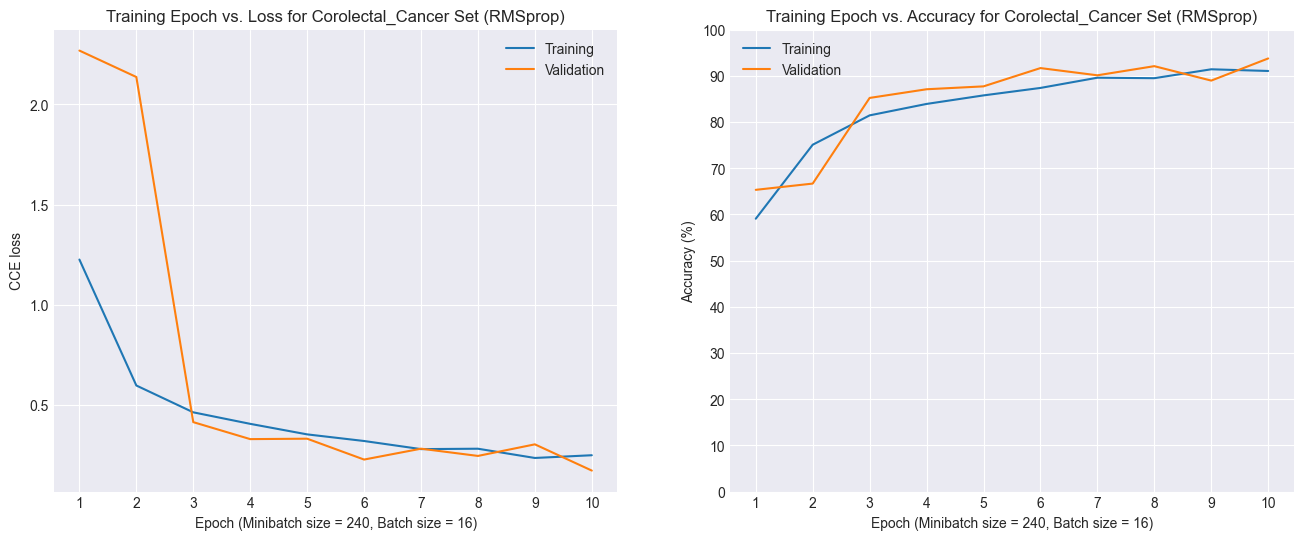

[INFO] Training Classification Report:
              precision    recall  f1-score   support

         MUS       0.91      0.90      0.91      1291
        NORM       0.95      0.96      0.95      1248
         STR       0.88      0.88      0.88      1301

    accuracy                           0.91      3840
   macro avg       0.91      0.91      0.91      3840
weighted avg       0.91      0.91      0.91      3840

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

         MUS       0.86      0.99      0.92       316
        NORM       0.99      0.99      0.99       332
         STR       0.98      0.83      0.90       312

    accuracy                           0.94       960
   macro avg       0.94      0.94      0.94       960
weighted avg       0.94      0.94      0.94       960

[INFO] Training Confusion Matrix:


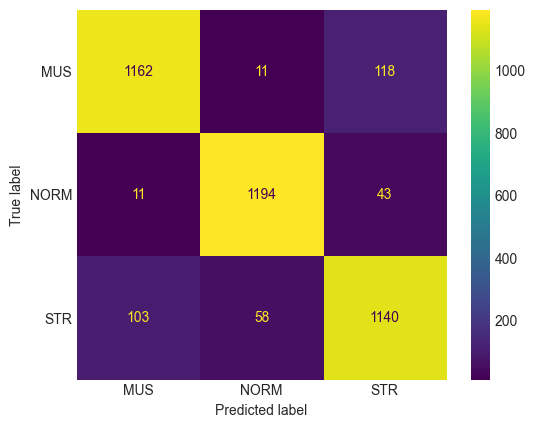

[INFO] Validation Confusion Matrix:


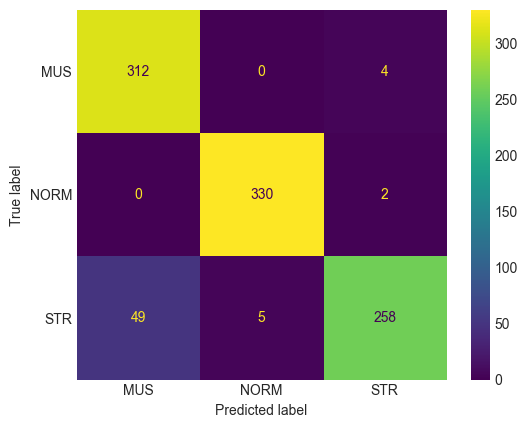

[INFO] Finished training w/RmsProp!


In [4]:
# Test set inference
print("[INFO] Starting training w/RmsProp... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 10, rmsprop, _val_data_loader=val_dataloader, _device=device, _optimizer_name="RMSprop")

print("[INFO] Finished training w/RmsProp!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/1, Loss: 0.1451, Accuracy: 93.92%
[INFO] Test Classification Report:
              precision    recall  f1-score   support

         MUS       0.88      0.98      0.93       393
        NORM       0.99      0.98      0.98       420
         STR       0.96      0.85      0.90       387

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200

[INFO] Test Confusion Matrix:


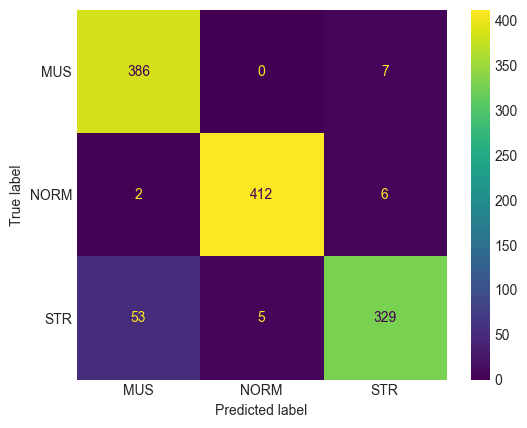

[INFO] Saved the pre-trained model!
[INFO] Finished training w/Rmsprop!


In [5]:
# Test set inference
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 1, rmsprop, _is_training=False, _device=device, _optimizer_name="Rmsprop")

print("[INFO] Finished training w/Rmsprop!")

In [6]:
return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
colorectal_model_extractor = create_feature_extractor(resnet_corolectal_cancer_model, return_nodes=return_nodes)


In [7]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(colorectal_model_extractor, train_dataloader, test_dataloader)


In [8]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


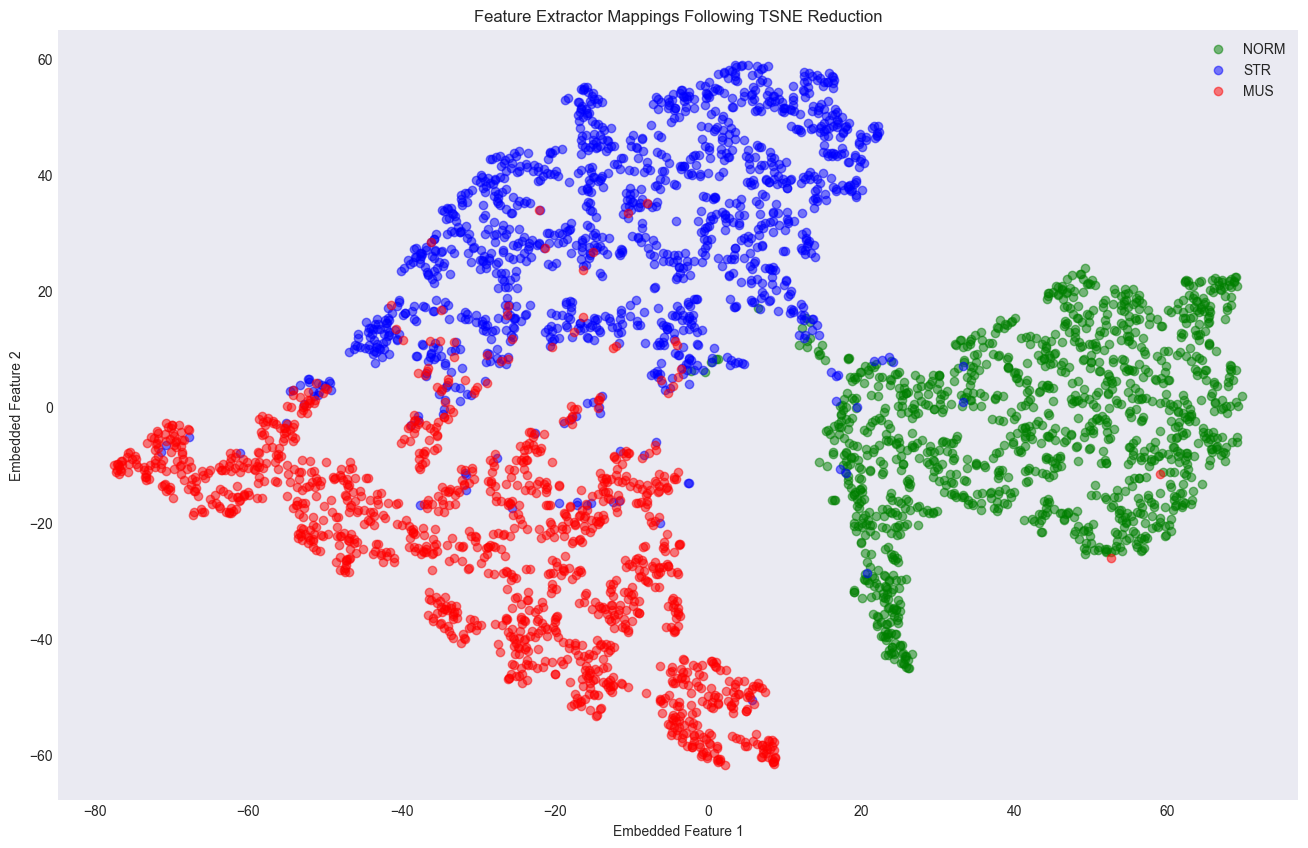

In [9]:
plot_tsne_embedding(embedding_dataframe)


#### SGD Optimizers

In [14]:
# Run this cell if a model was created with momentum and quick load is preferrable
resnet_corolectal_cancer_model.load_state_dict(torch.load("Models/ResNet_SGD_Corolectal_Cancer_pre_trained.tar"))


C:\Users\trist\AppData\Local\Temp\ipykernel_10564\2585574195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_corolectal_cancer_model.load_state_dict(torch.load("M

<All keys matched successfully>

[INFO] Starting training w/SGD... CHECK
[INFO] Epoch 1/10, Loss: 1.0250, Accuracy: 44.87%
[INFO] Validation loss: 1.1907, Validation accuracy: 54.79%
[INFO] Epoch 2/10, Loss: 0.8930, Accuracy: 53.78%
[INFO] Validation loss: 0.8607, Validation accuracy: 56.98%
[INFO] Epoch 3/10, Loss: 0.8566, Accuracy: 54.27%
[INFO] Validation loss: 0.8388, Validation accuracy: 55.10%
[INFO] Epoch 4/10, Loss: 0.8376, Accuracy: 55.81%
[INFO] Validation loss: 0.7943, Validation accuracy: 56.46%
[INFO] Epoch 5/10, Loss: 0.8081, Accuracy: 57.21%
[INFO] Validation loss: 0.8048, Validation accuracy: 54.27%
[INFO] Epoch 6/10, Loss: 0.7513, Accuracy: 61.61%
[INFO] Validation loss: 0.6809, Validation accuracy: 63.96%
[INFO] Epoch 7/10, Loss: 0.7034, Accuracy: 63.85%
[INFO] Validation loss: 0.6218, Validation accuracy: 67.19%
[INFO] Epoch 8/10, Loss: 0.6710, Accuracy: 67.97%
[INFO] Validation loss: 0.6055, Validation accuracy: 74.06%
[INFO] Epoch 9/10, Loss: 0.6096, Accuracy: 73.02%
[INFO] Validation loss: 0.5672

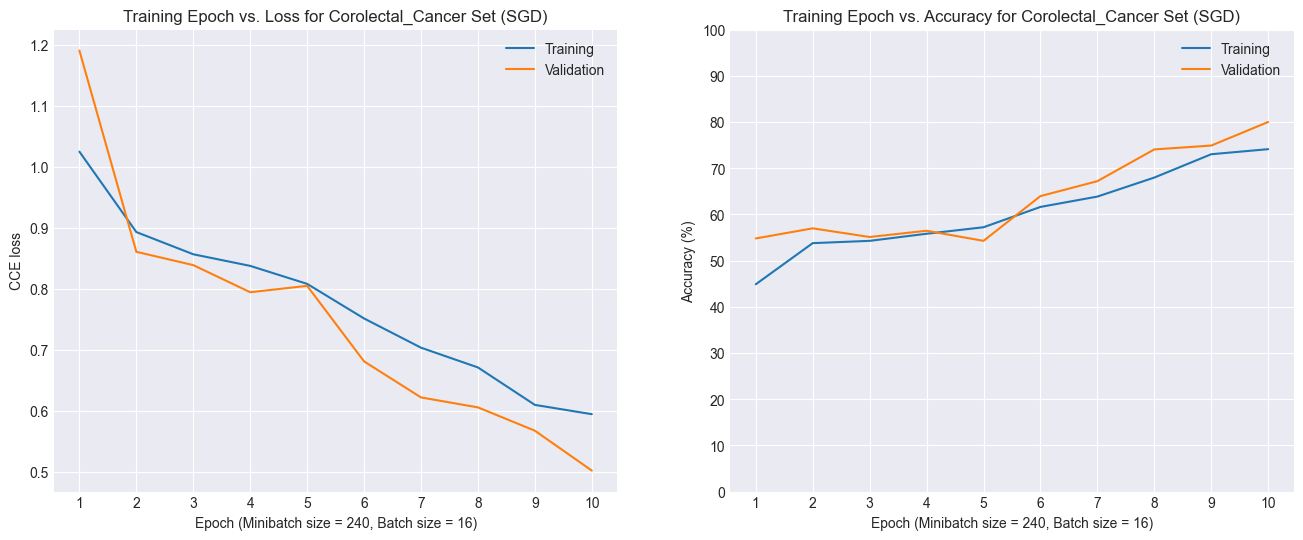

[INFO] Training Classification Report:
              precision    recall  f1-score   support

         MUS       0.71      0.71      0.71      1291
        NORM       0.85      0.90      0.87      1248
         STR       0.65      0.62      0.64      1301

    accuracy                           0.74      3840
   macro avg       0.74      0.74      0.74      3840
weighted avg       0.74      0.74      0.74      3840

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

         MUS       0.78      0.80      0.79       316
        NORM       0.91      0.87      0.89       332
         STR       0.71      0.72      0.71       312

    accuracy                           0.80       960
   macro avg       0.80      0.80      0.80       960
weighted avg       0.80      0.80      0.80       960

[INFO] Training Confusion Matrix:


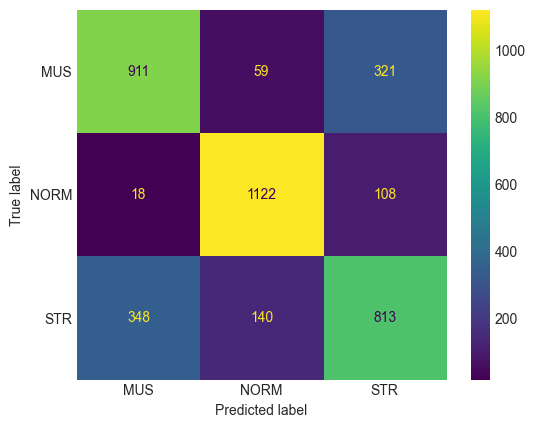

[INFO] Validation Confusion Matrix:


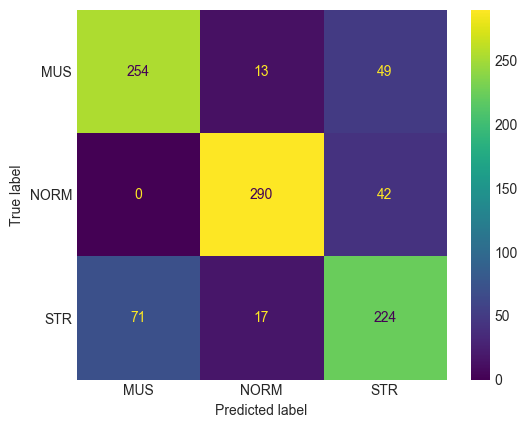

[INFO] Finished training w/SGD!


In [4]:
# Training loop for the model with SGD optimizer
print("[INFO] Starting training w/SGD... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 10, sgd_no_momentum, _val_data_loader=val_dataloader, _device=device)

print("[INFO] Finished training w/SGD!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/1, Loss: 0.4722, Accuracy: 82.08%
[INFO] Test Classification Report:
              precision    recall  f1-score   support

         MUS       0.79      0.81      0.80       393
        NORM       0.91      0.91      0.91       420
         STR       0.75      0.73      0.74       387

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200

[INFO] Test Confusion Matrix:


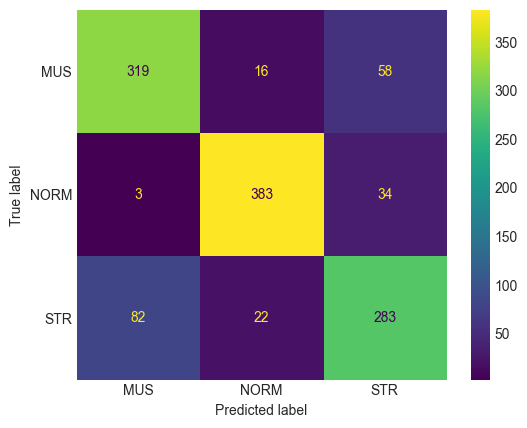

[INFO] Saved the pre-trained model!
[INFO] Finished training w/SGD !


In [5]:
# Test set inference for SGD optimizer
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 1, sgd_no_momentum, _is_training=False, _device=device)

print("[INFO] Finished training w/SGD !")

In [6]:
return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
colorectal_model_extractor = create_feature_extractor(resnet_corolectal_cancer_model, return_nodes=return_nodes)


In [7]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(colorectal_model_extractor, train_dataloader, test_dataloader)


In [8]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


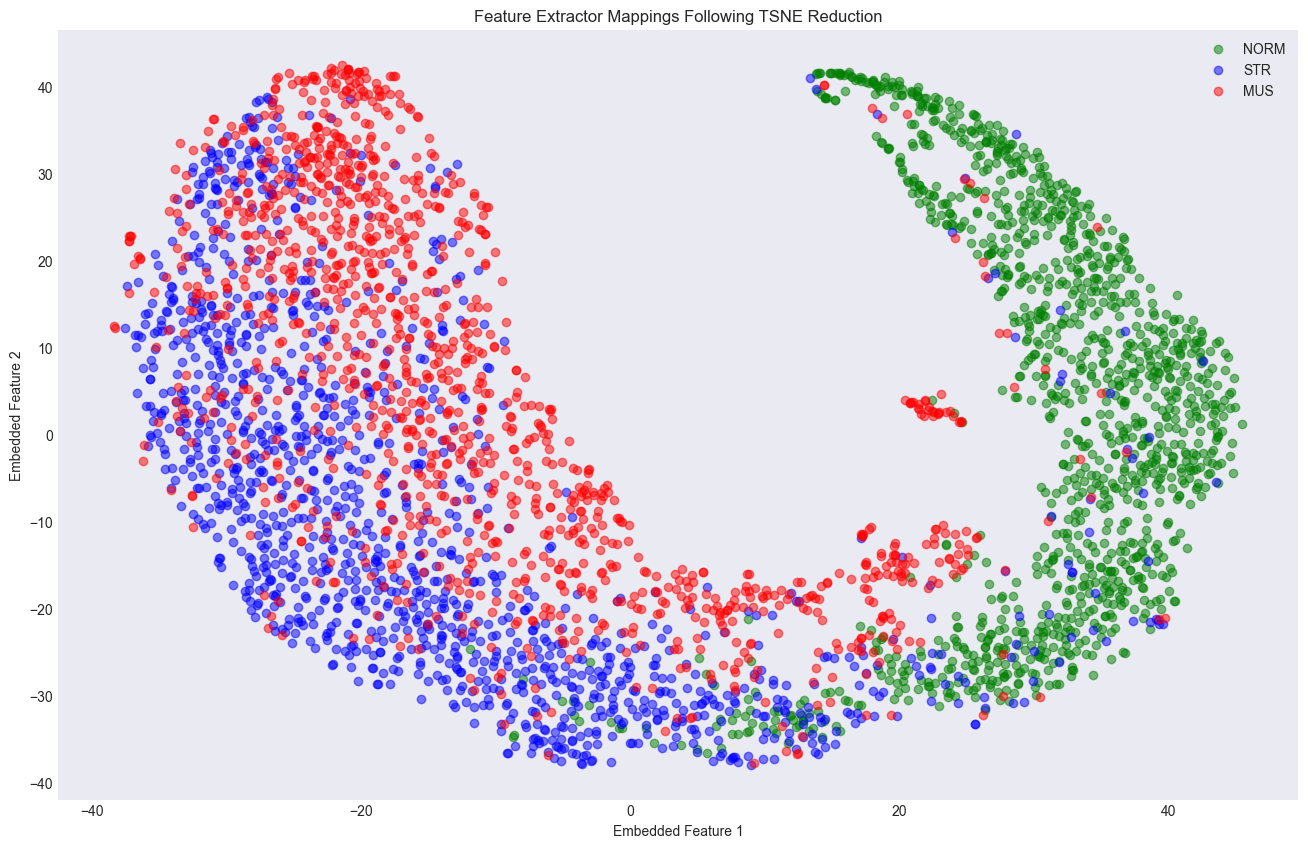

In [9]:
plot_tsne_embedding(embedding_dataframe)


#### Adam Optimizer

[INFO] Starting training w/Adam... CHECK
[INFO] Epoch 1/10, Loss: 0.7261, Accuracy: 70.65%
[INFO] Validation loss: 0.6341, Validation accuracy: 73.54%
[INFO] Epoch 2/10, Loss: 0.5217, Accuracy: 80.16%
[INFO] Validation loss: 0.8486, Validation accuracy: 66.67%
[INFO] Epoch 3/10, Loss: 0.3950, Accuracy: 84.53%
[INFO] Validation loss: 0.2501, Validation accuracy: 89.79%
[INFO] Epoch 4/10, Loss: 0.3179, Accuracy: 87.53%
[INFO] Validation loss: 0.2772, Validation accuracy: 89.17%
[INFO] Epoch 5/10, Loss: 0.2698, Accuracy: 89.64%
[INFO] Validation loss: 0.3389, Validation accuracy: 86.15%
[INFO] Epoch 6/10, Loss: 0.2526, Accuracy: 91.09%
[INFO] Validation loss: 0.1753, Validation accuracy: 94.58%
[INFO] Epoch 7/10, Loss: 0.2495, Accuracy: 90.44%
[INFO] Validation loss: 0.2172, Validation accuracy: 93.65%
[INFO] Epoch 8/10, Loss: 0.2499, Accuracy: 90.86%
[INFO] Validation loss: 0.3172, Validation accuracy: 88.02%
[INFO] Epoch 9/10, Loss: 0.1907, Accuracy: 92.94%
[INFO] Validation loss: 0.501

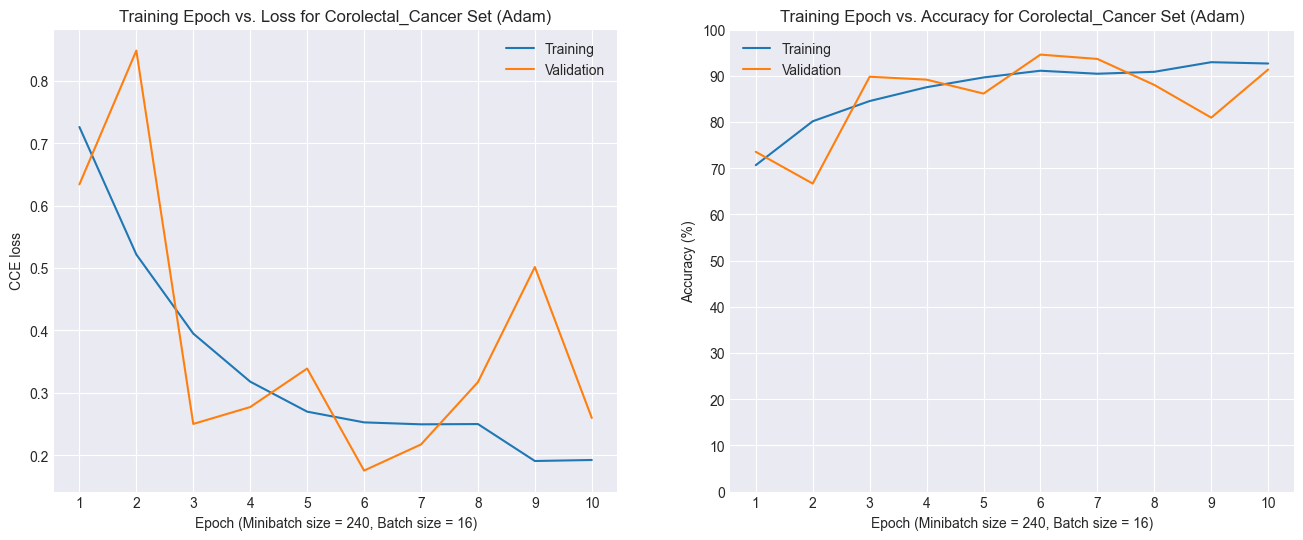

[INFO] Training Classification Report:
              precision    recall  f1-score   support

         MUS       0.92      0.92      0.92      1291
        NORM       0.96      0.97      0.96      1248
         STR       0.90      0.90      0.90      1301

    accuracy                           0.93      3840
   macro avg       0.93      0.93      0.93      3840
weighted avg       0.93      0.93      0.93      3840

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

         MUS       1.00      0.78      0.87       316
        NORM       0.99      0.97      0.98       332
         STR       0.79      0.99      0.88       312

    accuracy                           0.91       960
   macro avg       0.93      0.91      0.91       960
weighted avg       0.93      0.91      0.91       960

[INFO] Training Confusion Matrix:


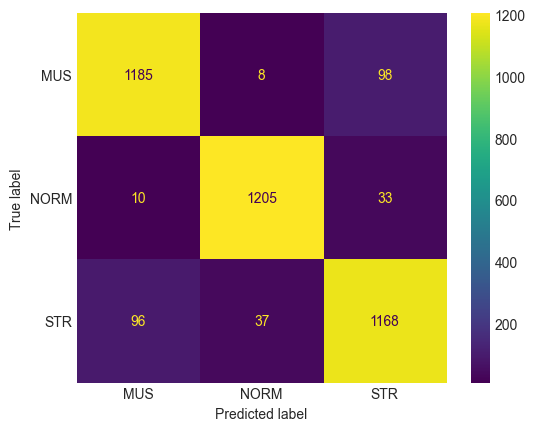

[INFO] Validation Confusion Matrix:


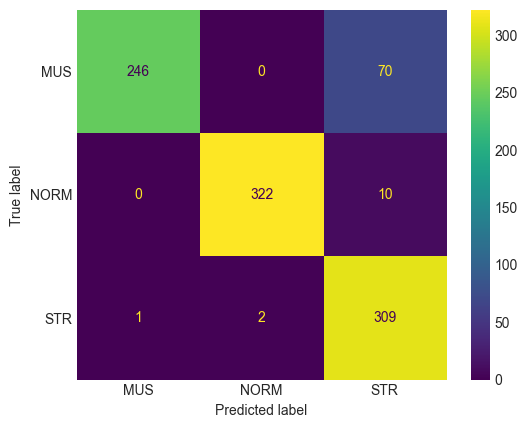

[INFO] Finished training w/Adam!


In [4]:
# Training loop for the model with Adam optimizer
print("[INFO] Starting training w/Adam... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 10, adam, _val_data_loader=val_dataloader, _device=device, _optimizer_name="Adam")

print("[INFO] Finished training w/Adam!")


[INFO] Begin inference on test set...
[INFO] Epoch 1/1, Loss: 0.2573, Accuracy: 92.00%
[INFO] Test Classification Report:
              precision    recall  f1-score   support

         MUS       0.99      0.79      0.88       393
        NORM       0.99      0.97      0.98       420
         STR       0.81      0.99      0.89       387

    accuracy                           0.92      1200
   macro avg       0.93      0.92      0.92      1200
weighted avg       0.93      0.92      0.92      1200

[INFO] Test Confusion Matrix:


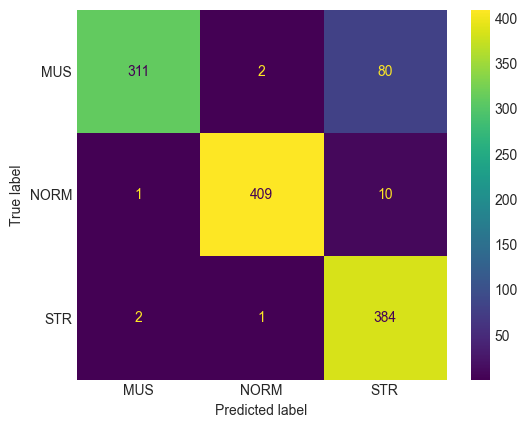

[INFO] Saved the pre-trained model!
[INFO] Finished training w/Adam !


In [6]:
# Test set inference for Adam optimizer
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 1, adam, _is_training=False, _device=device, _optimizer_name="Adam")

print("[INFO] Finished training w/Adam !")


In [7]:
return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
colorectal_model_extractor = create_feature_extractor(resnet_corolectal_cancer_model, return_nodes=return_nodes)


In [8]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(colorectal_model_extractor, train_dataloader, test_dataloader)


In [9]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


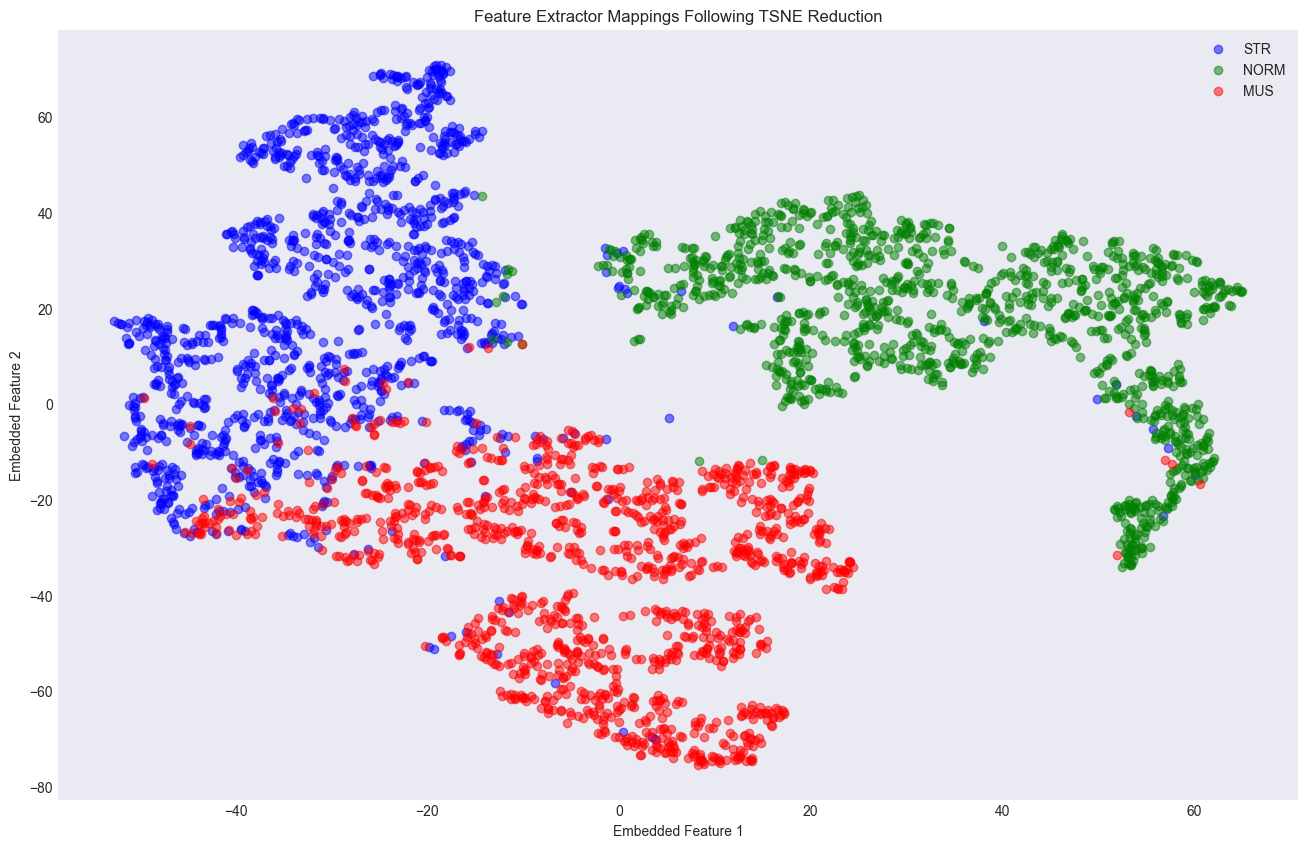

In [10]:
plot_tsne_embedding(embedding_dataframe)
